In [1]:
import argparse
import errno
import os

import sys
sys.path.insert(0, '/global/homes/x/xiaocan/mhd/athena/vis/python')
import athena_read

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib.colors import LogNorm

plt.rcParams['figure.dpi'] = 100

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

In [2]:
def mkdir_p(path):
    """Create directory recursively
    """
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [3]:
def get_mhd_config(mhd_run_dir, config_name):
    """Get MHD run information from the configuration file

    Arguments:
        mhd_run_dir (string): MHD run directory
        config_name (string): MHD simulation configuration file name
    """
    with open(mhd_run_dir + "/" + config_name) as f:
        contents = f.readlines()
    f.close()
    mhd_config = {}
    for line in contents:
        if "<" in line and ">" in line and "<" == line[0]:
            block_name = line[1:line.find(">")]
            mhd_config[block_name] = {}
        else:
            if line[0] != "#" and "=" in line:
                line_splits = line.split("=")
                tail = line_splits[1].split("\n")
                data = tail[0].split("#")
                ltmp = line_splits[0].strip()
                try:
                    mhd_config[block_name][ltmp] = float(data[0])
                except ValueError:
                    mhd_config[block_name][ltmp] = data[0].strip()
    return mhd_config

In [4]:
def plot_jz(mhd_config, tframe, show_plot=False):
    """Plot the z-component of the current density
    """
    run_name = mhd_config["run_name"]
    run_dir = mhd_config["run_dir"]
    output_type = "reconnection.prim"
    fname = run_dir + output_type + "." + str(tframe).zfill(5) + ".athdf"
    fdata = athena_read.athdf(fname)
    dxm = fdata["x1f"][1] - fdata["x1f"][0]
    dym = fdata["x2f"][1] - fdata["x2f"][0]
    bx = fdata['Bcc1'][0]
    by = fdata['Bcc2'][0]
    jz = np.gradient(by, dxm, axis=1) - np.gradient(bx, dym, axis=0)
    
    xmin = mhd_config["mesh"]["x1min"]
    xmax = mhd_config["mesh"]["x1max"]
    ymin = mhd_config["mesh"]["x2min"]
    ymax = mhd_config["mesh"]["x2max"]
    sizes = [xmin, xmax, ymin, ymax]
    fig = plt.figure(figsize=[4.5, 4])
    rect = [0.11, 0.12, 0.7, 0.8]
    ax = fig.add_axes(rect)
    img = ax.imshow(jz, extent=sizes, cmap=plt.cm.seismic,
                    vmin=-200, vmax=200,
                    aspect='auto', origin='lower')
    rect[0] += rect[2] + 0.02
    rect[2] = 0.03
    cbar_ax = fig.add_axes(rect)
    cbar = fig.colorbar(img, cax=cbar_ax, extend='both')
    ax.tick_params(labelsize=8)
    cbar.ax.tick_params(labelsize=8)
    ax.set_xlabel(r'$x$', fontsize=10)
    ax.set_ylabel(r'$y$', fontsize=10)
    cbar.ax.set_ylabel(r'$j_z$', fontsize=10)
    dt_out = mhd_config["output1"]["dt"]
    tva = dt_out * tframe / (ymax - ymin)
    title = r'$t = ' + "{:10.2f}".format(tva) + r'\tau_A$'
    title += ' (frame: %d)' % tframe
    fig.suptitle(title, fontsize=10)
    img_path = 'img/jz/'
    mkdir_p(img_path)
    plt.savefig(img_path + 'jz_' + str(tframe) + '.pdf', dpi=200)
    if not show_plot:
        plt.close()

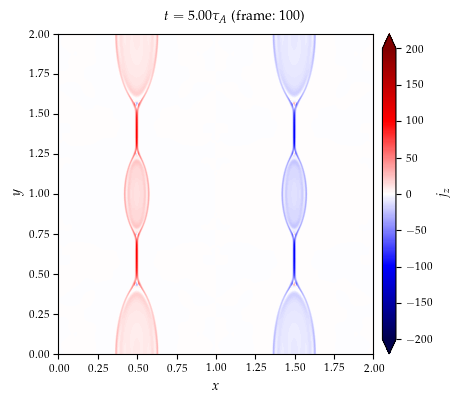

In [5]:
mhd_run_name = "athena_reconnection_test"
mhd_run_dir = "/global/cscratch1/sd/xiaocan/athena_reconnection_test/"
mhd_config = get_mhd_config(mhd_run_dir, "athinput.reconnection")
mhd_config["run_name"] = mhd_run_name
mhd_config["run_dir"] = mhd_run_dir
plot_jz(mhd_config, 100, show_plot=True)